# Mine domain #1. Extract subgroups with high concentration of PHAs

In [1]:
import pickle
from copy import copy, deepcopy
import numpy as np
import pandas as pd
from sklearn import neighbors, svm
import matplotlib as mpl

# Import Asterion modules
import read_database as rdb
import learn_data as ld
import asterion_learn as al
import visualize_data as vd

# Plotting settings for the current notebook
%matplotlib inline
font = {'size': 14}
mpl.rc('font', **font)
plotgrid = np.array([[0.0, 0.0], [1.0, 1.0]])

** Load generated and real NEAs from the domain #1 **

In [3]:
dirpath = './asteroid_data/'
real_datasets = ['haz_real', 'nohaz_real']
gen_datasets = ['haz_gen', 'nohaz_gen']
genu_datasets = ['haz_gen', 'nohaz_gen']
name_suffixes = ['_dom1.p', '_dom1_rest.p']

In [4]:
dumps_real = [dirpath + ds + ns for ns in name_suffixes for ds in real_datasets]
dumps_gen = [dirpath + ds + ns for ns in name_suffixes for ds in gen_datasets]
dumps_genu = [dirpath + ds + ns for ns in name_suffixes for ds in genu_datasets]

haz_real, nohaz_real, haz_real_rest, nohaz_real_rest = map(rdb.loadObject, dumps_real)
haz_gen, nohaz_gen, haz_gen_rest, nohaz_gen_rest = map(rdb.loadObject, dumps_gen)
haz_genu, nohaz_genu, haz_genu_rest, nohaz_genu_rest = map(rdb.loadObject, dumps_genu)

** Investigate distributions of orbital parameters for the domain #1 **

In [5]:
# vd.display_allparams([haz_gen, nohaz_gen], vd.combs, vd.colnames)

## Cut off non-hazardous asteroids with high values of q

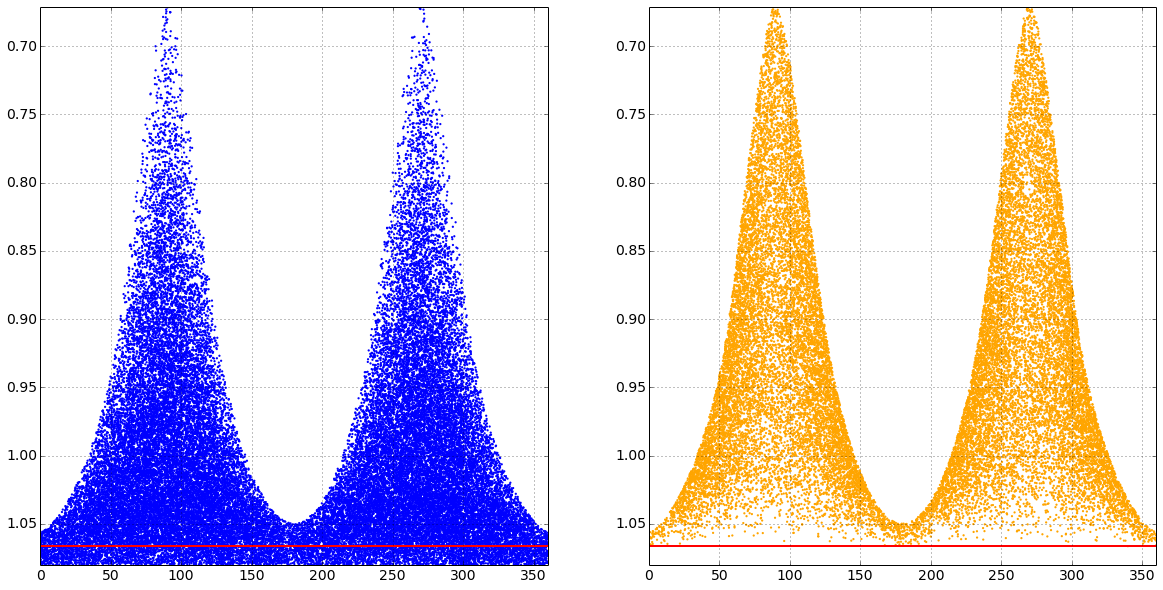

In [7]:
q_split = 1.066
cutcol = ['w', 'q']
haz_gen_cut, nohaz_gen_cut = ld.cut_params(haz_gen, nohaz_gen, cutcol)
p1, p2 = [[0.0, q_split], [360.0, q_split]]
vd.linearcut_plot(p1, p2, haz_gen_cut, nohaz_gen_cut, invertaxes=[0,1])

In [8]:
haz_gen_dom1, haz_gen_dom1__ = ld.split_by_colval(haz_gen, 'q', q_split)
nohaz_gen_dom1, nohaz_gen_dom1__ = ld.split_by_colval(nohaz_gen, 'q', q_split)

In [9]:
haz_genu_dom1, haz_genu_dom1__ = ld.split_by_colval(haz_genu, 'q', q_split)
nohaz_genu_dom1, nohaz_genu_dom1__ = ld.split_by_colval(nohaz_genu, 'q', q_split)

---
## Extract Atiras and Atens

In [10]:
haz_extracted_aa = []
nohaz_trapped_aa = []

In [11]:
haz_gen_atiras, haz_gen_atiras_num = rdb.get_atiras(haz_gen_dom1)
nohaz_gen_atiras, nohaz_gen_atiras_num = rdb.get_atiras(nohaz_gen_dom1)

In [12]:
haz_gen_atens, naz_gen_atens_num = rdb.get_atens(haz_gen_dom1)
nohaz_gen_atens, nohaz_gen_atens_num = rdb.get_atens(nohaz_gen_dom1)

In [13]:
haz_gen_atiras_atens = pd.concat((haz_gen_atiras, haz_gen_atens))
nohaz_gen_atiras_atens = pd.concat((nohaz_gen_atiras, nohaz_gen_atens))
haz_gen_atiras_atens_num = len(haz_gen_atiras_atens)
nohaz_gen_atiras_atens_num = len(nohaz_gen_atiras_atens)

In [14]:
# print haz_gen_atiras_atens_num, nohaz_gen_atiras_atens_num

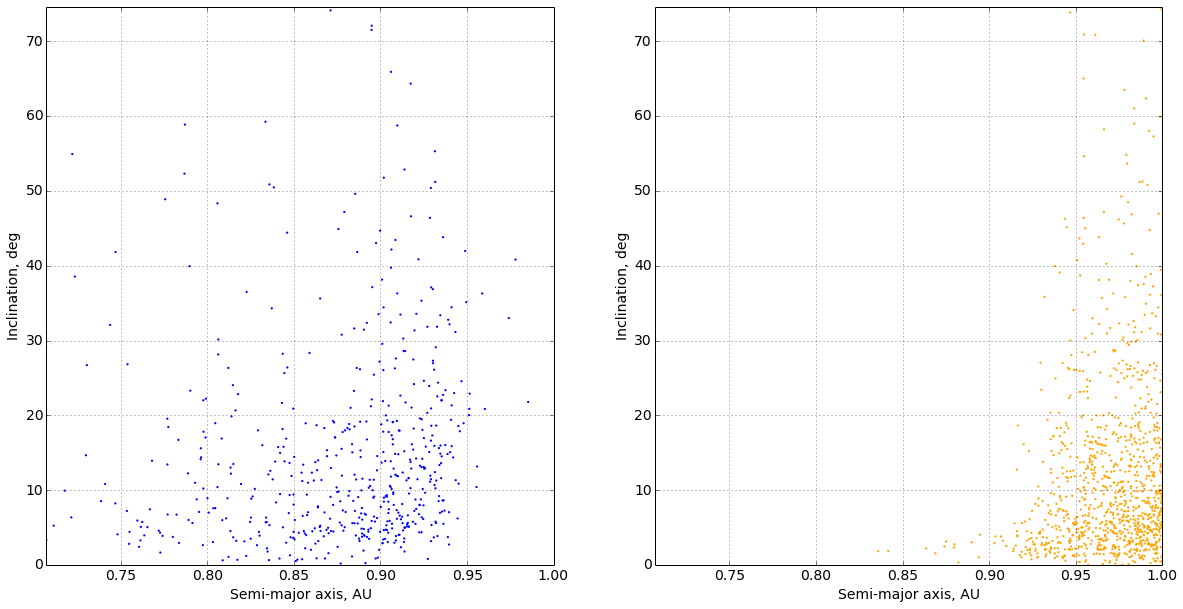

In [20]:
cutcol = ['a', 'i']
labels = [vd.colnames[nm] for nm in cutcol]
vd.display_param2d(cutcol, labels, [haz_gen_atiras_atens, nohaz_gen_atiras_atens])

In [21]:
# vd.display_allparams([atens_haz, atens_nohaz], vd.combs, vd.colnames)

In [22]:
# vd.display_allparams([atiras_atens_haz, atiras_atens_nohaz], vd.combs, vd.colnames)

In [23]:
clf_aa_ai = svm.LinearSVC()
splitres = al.split_by_clf(clf_aa_ai, cutcol, haz_gen_atiras_atens, 
                                              nohaz_gen_atiras_atens)
haz_gen_aa_ai, nohaz_gen_aa_ai = splitres[0]
haz_gen_aa_ai__, nohaz_gen_aa_ai__ = splitres[1]
aa_ai_sc = splitres[2]

purity of PHA region: 0.923357664234
number of PHAs in the PHA region: 1012
number of NHAs in the PHA region: 84

purity of NHA region: 0.919765166341
number of PHAs in the NHA region: 41
number of NHAs in the NHA region: 470

fraction of correctly classified PHAs: 0.96106362773


In [24]:
# vd.display_param2d(cutcol, labels, [haz_gen_aa_ai, nohaz_gen_aa_ai])

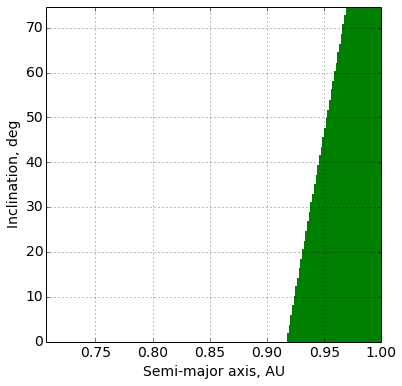

In [25]:
vd.plot_classifier(plotgrid, clf_aa_ai, num=200, figsize=(6,6), scales=aa_ai_sc, 
                   labels=labels, cmap='ocean_r')

In [27]:
haz_extracted_aa.append(haz_gen_aa_ai)
nohaz_trapped_aa.append(nohaz_gen_aa_ai)

---
## Extract Apollos

In [103]:
haz_extracted_ap = []
nohaz_trapped_ap = []

In [32]:
haz_gen_apollo, haz_ap_num = rdb.get_apollos(haz_gen_dom1)
nohaz_gen_apollo, nohaz_ap_num = rdb.get_apollos(nohaz_gen_dom1)

In [33]:
# vd.display_allparams([apollos_haz, apollos_nohaz], vd.combs, vd.colnames)

### 1. Apollo multisplit approach

In [104]:
haz_extracted_ap_ms = copy(haz_extracted_ap)
nohaz_trapped_ap_ms = copy(nohaz_trapped_ap)

### Split Apollos by the 'q-i' plane

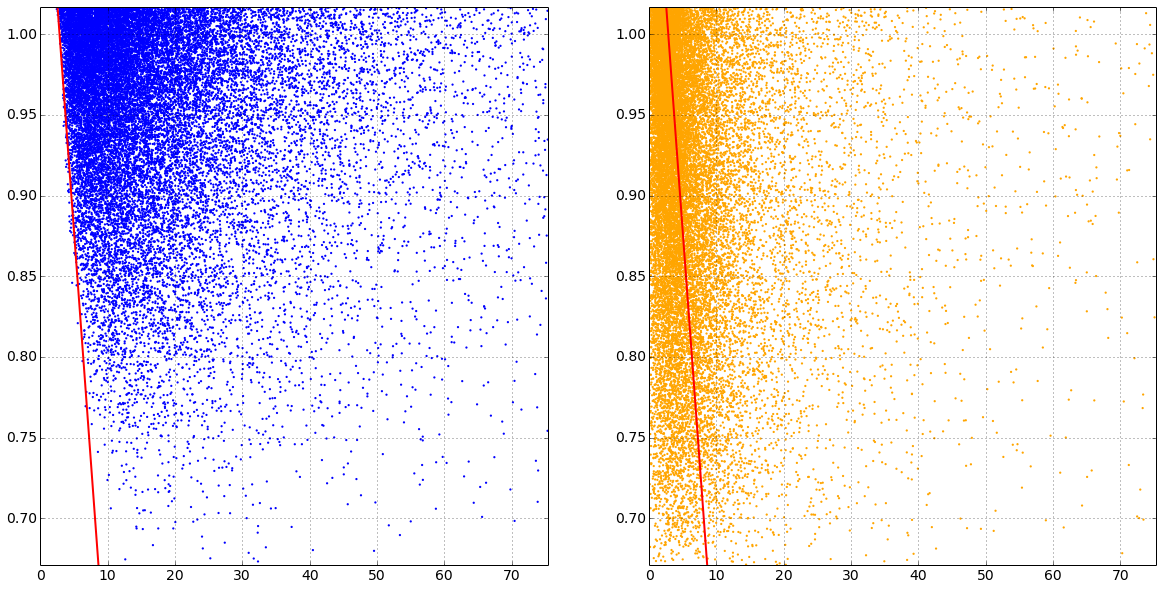

In [35]:
cutcol = ['i', 'q']
haz_cut, nohaz_cut = ld.cut_params(haz_gen_apollo, nohaz_gen_apollo, cutcol)
p1, p2 = [[2.5, 1.02], [9.0, 0.65]]
vd.linearcut_plot(p1, p2, haz_cut, nohaz_cut)

In [36]:
apollo_qi, apollo_qi__ = ld.split_by_line(haz_gen_apollo, nohaz_gen_apollo, [p1, p2], cutcol)
haz_gen_apollo_qi, nohaz_gen_apollo_qi = apollo_qi
haz_gen_apollo_qi__, nohaz_gen_apollo_qi__ = apollo_qi__

PHA purity of the left subset: 0.994832797114
PHA purity of the right subset: 0.339817032697


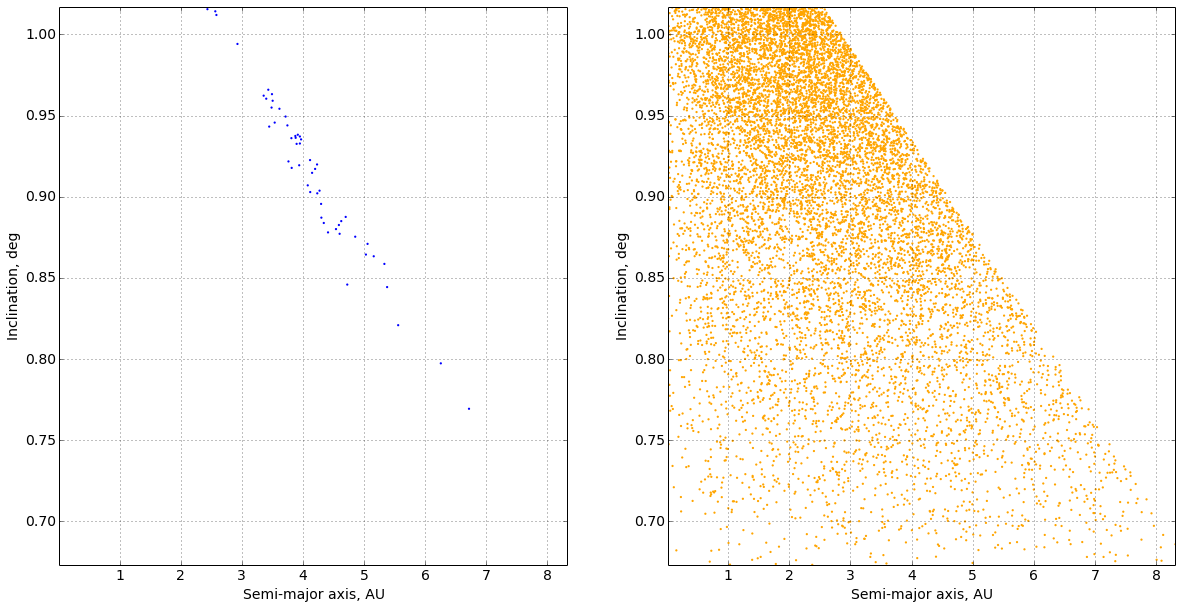

In [37]:
vd.display_param2d(cutcol, labels, [haz_gen_apollo_qi, nohaz_gen_apollo_qi])

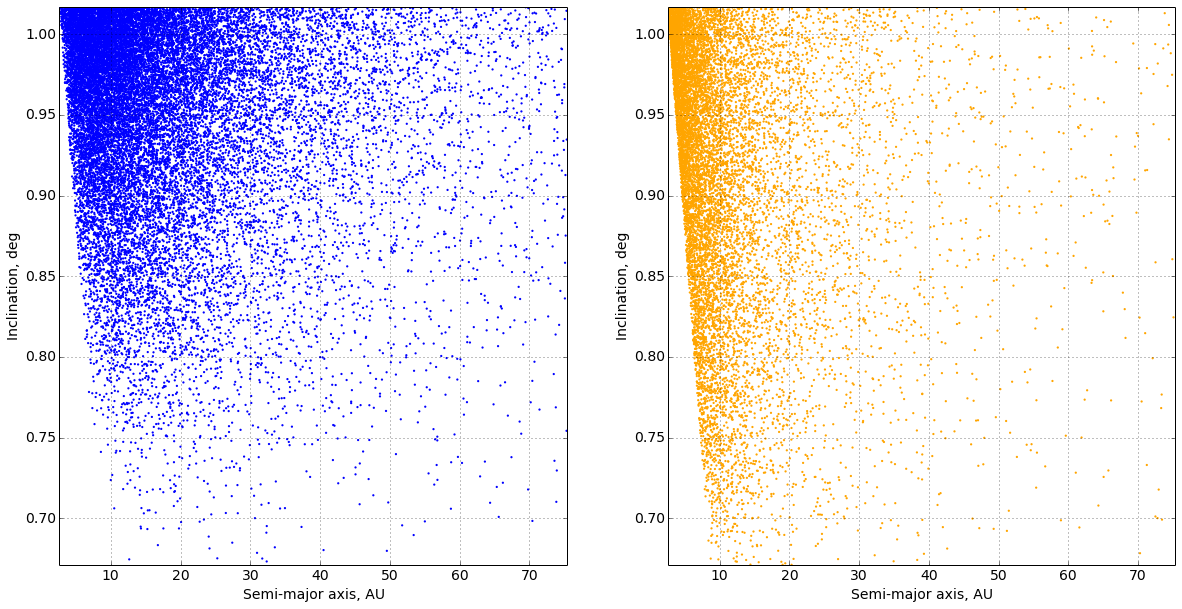

In [38]:
vd.display_param2d(cutcol, labels, [haz_gen_apollo_qi__, nohaz_gen_apollo_qi__])

In [105]:
haz_extracted_ap_ms.append(haz_gen_apollo_qi)
nohaz_trapped_ap_ms.append(nohaz_gen_apollo_qi)

### Split right subset of apollos by the 'q-a' plane

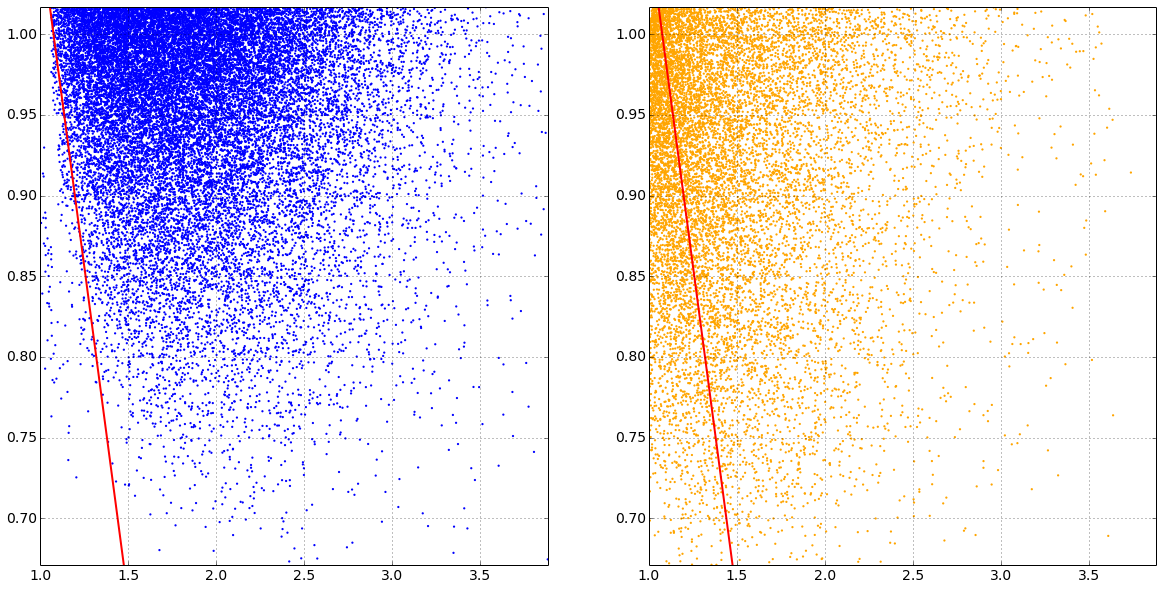

In [40]:
cutcol = ['a', 'q']
haz_cut, nohaz_cut = ld.cut_params(haz_gen_apollo_qi__, nohaz_gen_apollo_qi__, cutcol)
p1, p2 = [[1.05, 1.02], [1.5, 0.65]]
vd.linearcut_plot(p1, p2, haz_cut, nohaz_cut)

In [41]:
splitres = ld.split_by_line(haz_gen_apollo_qi__, nohaz_gen_apollo_qi__, [p1, p2], cutcol)

haz_gen_apollo_qa, nohaz_gen_apollo_qa = splitres[0]
haz_gen_apollo_qa__, nohaz_gen_apollo_qa__ = splitres[1]

PHA purity of the left subset: 0.929450615431
PHA purity of the right subset: 0.277107279693


In [106]:
haz_extracted_ap_ms.append(haz_gen_apollo_qa)
nohaz_trapped_ap_ms.append(nohaz_gen_apollo_qa)

### Deep analysis of the rest of Apollos

In [43]:
# vd.display_allparams([haz_gen_apollo_qa__, nohaz_gen_apollo_qa__], vd.combs, vd.colnames)

** Amplify datasets by their symmetric copies over the 'w' parameter **

In [44]:
haz_gen_apollo_qa__se = ld.add_doublemirror_column(haz_gen_apollo_qa__, 'w', 180.0)
nohaz_gen_apollo_qa__se = ld.add_doublemirror_column(nohaz_gen_apollo_qa__, 'w', 180.0)

### a) Extract boundary layers from the right subset of apollos

In [107]:
haz_extracted_ap_ms1 = copy(haz_extracted_ap_ms)
nohaz_trapped_ap_ms1 = copy(nohaz_trapped_ap_ms)

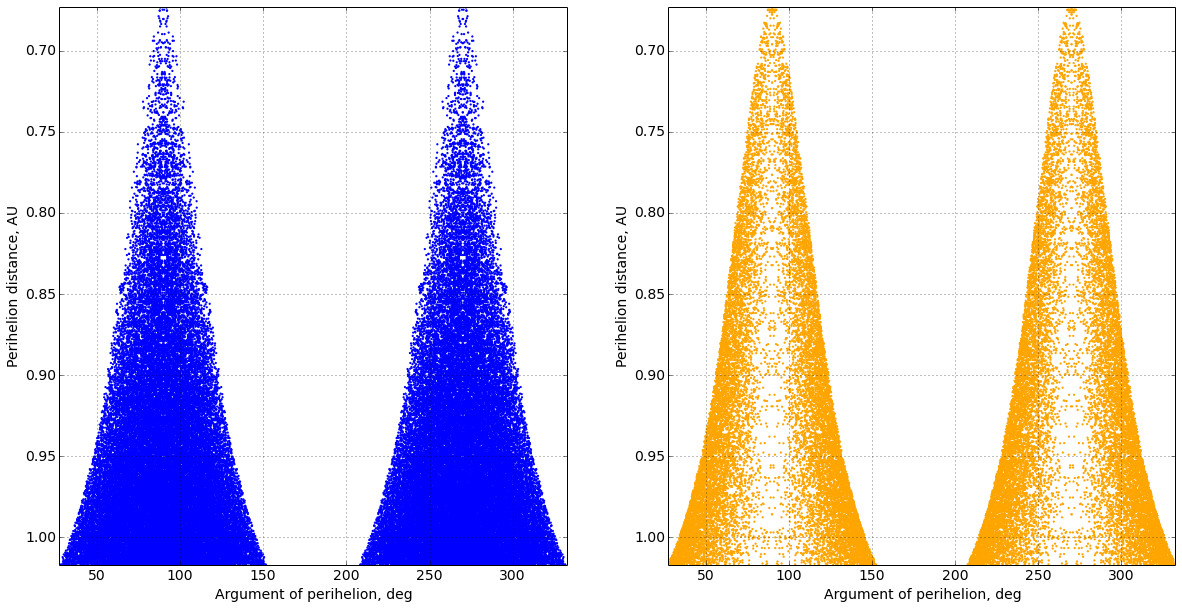

In [46]:
cutcol = ['w', 'q']
labels = [vd.colnames[nm] for nm in cutcol]
vd.display_param2d(cutcol, labels, [haz_gen_apollo_qa__se, nohaz_gen_apollo_qa__se], invertaxes=[0,1])

In [47]:
clf_apollo_wq = svm.SVC(gamma=5., C=100.0, class_weight={1: 3.0}) # 2.8
splitres = al.split_by_clf(clf_apollo_wq, cutcol, haz_gen_apollo_qa__se, 
                                                  nohaz_gen_apollo_qa__se,
                                                  haz_gen_apollo_qa__, 
                                                  nohaz_gen_apollo_qa__)

haz_gen_apollo_wq, nohaz_gen_apollo_wq = splitres[0]
haz_gen_apollo_wq__, nohaz_gen_apollo_wq__ = splitres[1]
apollo_wq_sc = splitres[2]

purity of PHA region: 0.527287993283
number of PHAs in the PHA region: 6908
number of NHAs in the PHA region: 6193

purity of NHA region: 0.902793786706
number of PHAs in the NHA region: 1771
number of NHAs in the NHA region: 16448

fraction of correctly classified PHAs: 0.795944233207


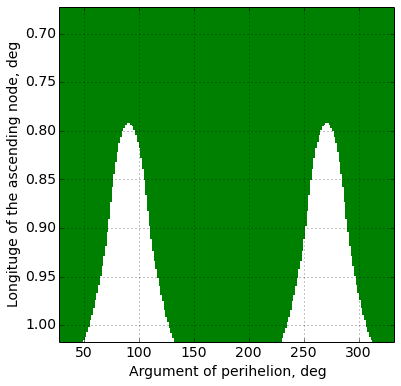

In [138]:
vd.plot_classifier(plotgrid, clf_apollo_wq, num=200, figsize=(7,7), scales=apollo_wq_sc, 
                   labels=labels, cmap='ocean_r', invertaxes=[0,1])

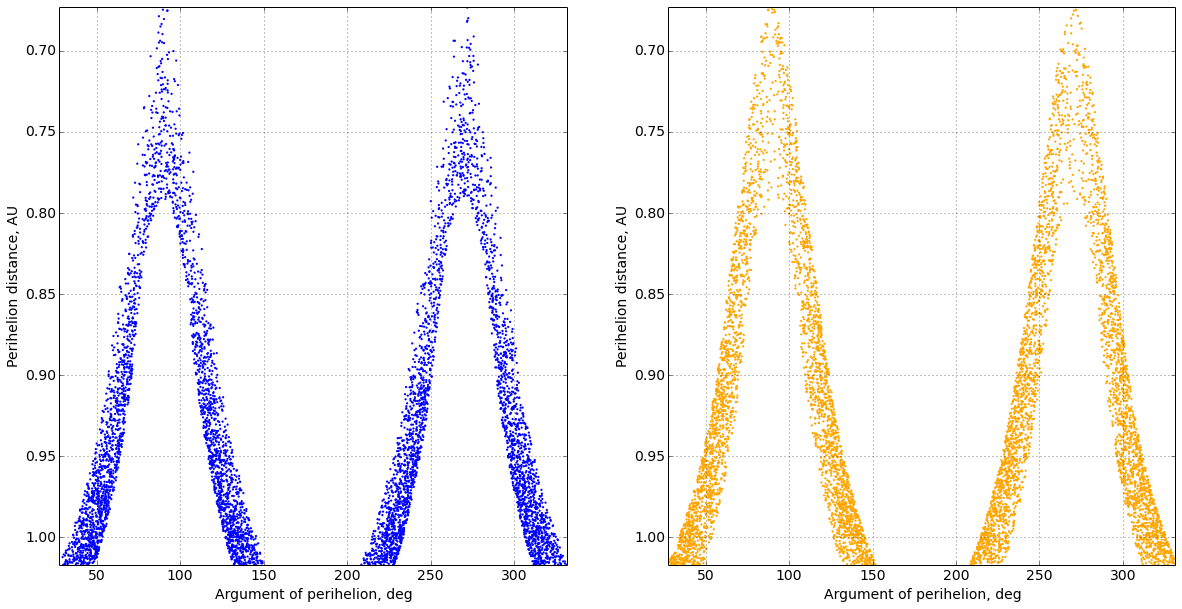

In [49]:
# cutcol = ['w', 'q']
# labels = [vd.colnames[nm] for nm in cutcol]
vd.display_param2d(cutcol, labels, [haz_gen_apollo_wq, nohaz_gen_apollo_wq], invertaxes=[0,1])

#### Split boundary layer of the Apollo subset by the 'a-i' surface

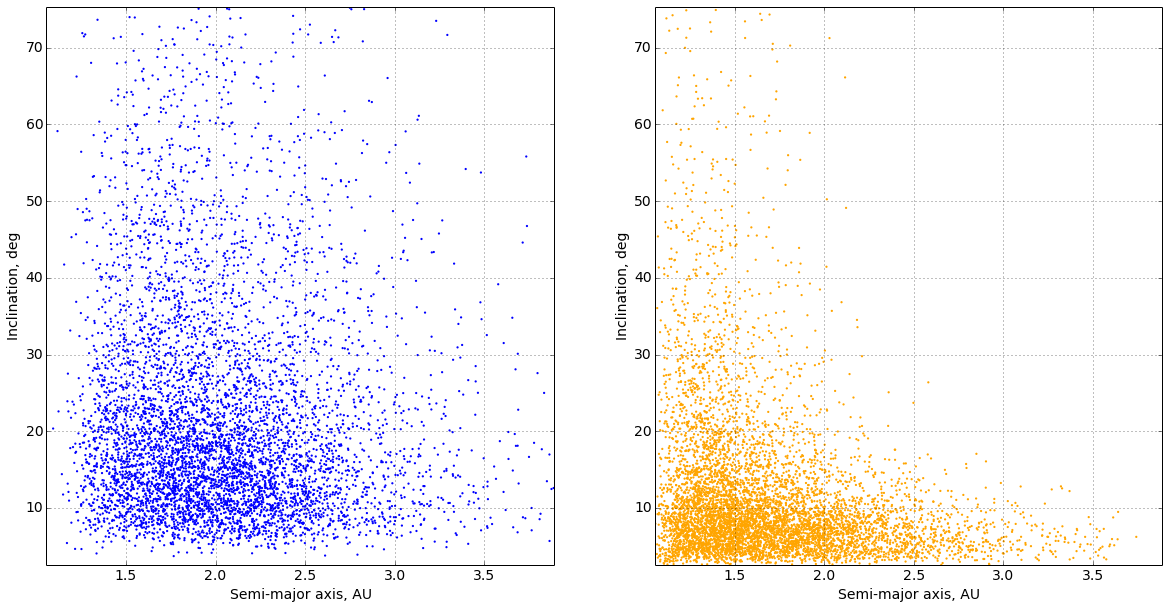

In [50]:
cutcol = ['a', 'i']
labels = [vd.colnames[nm] for nm in cutcol]
vd.display_param2d(cutcol, labels, [haz_gen_apollo_wq, nohaz_gen_apollo_wq]) #invertaxes=[0,1]

In [51]:
clf_apollo_ai = svm.SVC(gamma=0.67, C=10000.0, class_weight={0: 2.5})
# clf = svm.SVC(gamma=67.0, C=100.0, class_weight={0: 2.5})
splitres = al.split_by_clf(clf_apollo_ai, cutcol, haz_gen_apollo_wq, nohaz_gen_apollo_wq)

haz_gen_apollo_ai, nohaz_gen_apollo_ai = splitres[0]
haz_gen_apollo_ai__, nohaz_gen_apollo_ai__ = splitres[1]
apollo_ai_sc = splitres[2]

purity of PHA region: 0.897419214921
number of PHAs in the PHA region: 4138
number of NHAs in the PHA region: 473

purity of NHA region: 0.673733804476
number of PHAs in the NHA region: 2770
number of NHAs in the NHA region: 5720

fraction of correctly classified PHAs: 0.599015634047


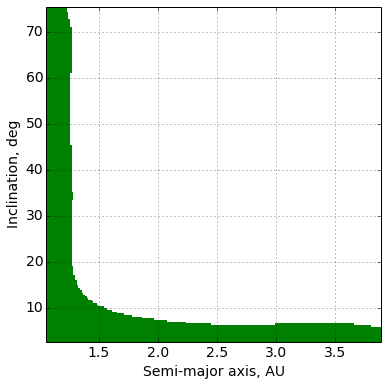

In [52]:
vd.plot_classifier(plotgrid, clf_apollo_ai, num=200, figsize=(7,7), 
                   scales=apollo_ai_sc, labels=labels, cmap='ocean_r')

In [108]:
haz_extracted_ap_ms1.append(haz_gen_apollo_ai)
nohaz_trapped_ap_ms1.append(nohaz_gen_apollo_ai)

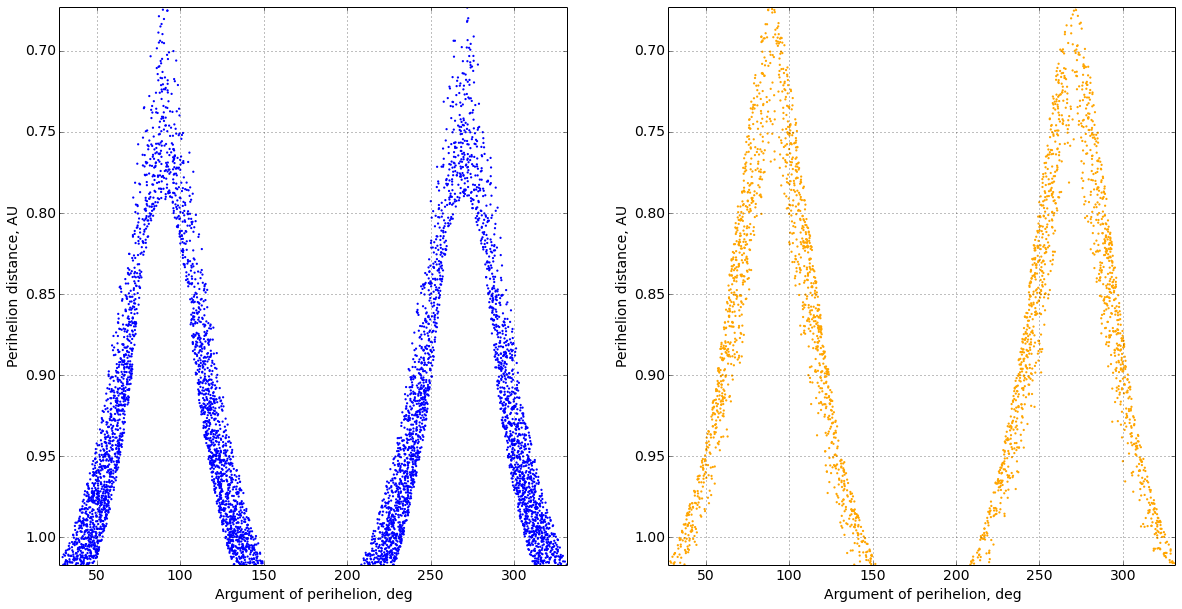

In [55]:
cutcol = ['w', 'q']
labels = [vd.colnames[nm] for nm in cutcol]
vd.display_param2d(cutcol, labels, [haz_gen_apollo_ai__, nohaz_gen_apollo_ai__], invertaxes=[0,1])

#### Extract PHA volume from the rest of 'a-i' split

In [56]:
# vd.display_allparams([haz_gen_apollo_ai__, nohaz_gen_apollo_ai__], vd.combs, vd.colnames)

In [57]:
print len(haz_gen_apollo_ai__)
print len(nohaz_gen_apollo_ai__)

2770
5720


** Amplify datasets by their symmetric copies over the 'w' parameter **

In [58]:
haz_gen_apollo_ai__se = ld.add_doublemirror_column(haz_gen_apollo_ai__, 'w', 180.0)
nohaz_gen_apollo_ai__se = ld.add_doublemirror_column(nohaz_gen_apollo_ai__, 'w', 180.0)

** Split rest of Apollos by the 'w-q-i' surface **

In [59]:
cutcol = ['w', 'q', 'i'] # a
# clf_apollo_wqi = svm.SVC(gamma=50.0, C=1.0, class_weight={0: 1.5})
clf_apollo_wqi = svm.SVC(gamma=50.0, C=0.3, class_weight={0: 1.5})
# clf = svm.SVC(gamma=30.0, C=0.8, class_weight={0: 1.5})
splitres = al.split_by_clf(clf_apollo_wqi, cutcol, haz_gen_apollo_ai__se,
                                                   nohaz_gen_apollo_ai__se,
                                                   haz_gen_apollo_ai__,
                                                   nohaz_gen_apollo_ai__)

haz_gen_apollo_wqi, nohaz_gen_apollo_wqi = splitres[0]
haz_gen_apollo_wqi__, nohaz_gen_apollo_wqi__ = splitres[1]
apollo_wqi_sc = splitres[2]

purity of PHA region: 0.87147766323
number of PHAs in the PHA region: 1268
number of NHAs in the PHA region: 187

purity of NHA region: 0.786496090974
number of PHAs in the NHA region: 1502
number of NHAs in the NHA region: 5533

fraction of correctly classified PHAs: 0.457761732852


** Prepare 'w-q' domain mask to exclude out-of-domain points from the plot **

In [60]:
cutcol = ['w', 'q']
labels = [vd.colnames[nm] for nm in cutcol]

clfmask = svm.SVC(gamma=50.0, C=100.0, class_weight={1: 10})
clfmask = al.sgmask_clf(haz_gen_apollo_qa__se, nohaz_gen_apollo_qa__se, 
                        haz_genu_rest, nohaz_genu_rest, clfmask, cutcol)

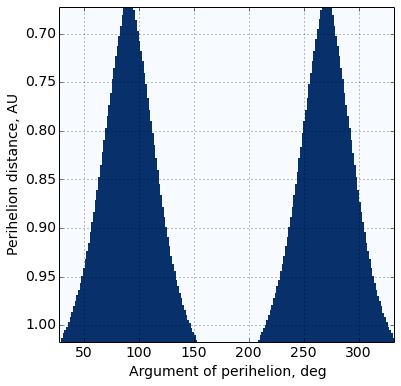

In [61]:
vd.plot_classifier(plotgrid, clfmask, num=200, figsize=(6,6), labels=labels, 
                   cmap='Blues', scales=apollo_wqi_sc, invertaxes=[0,1])

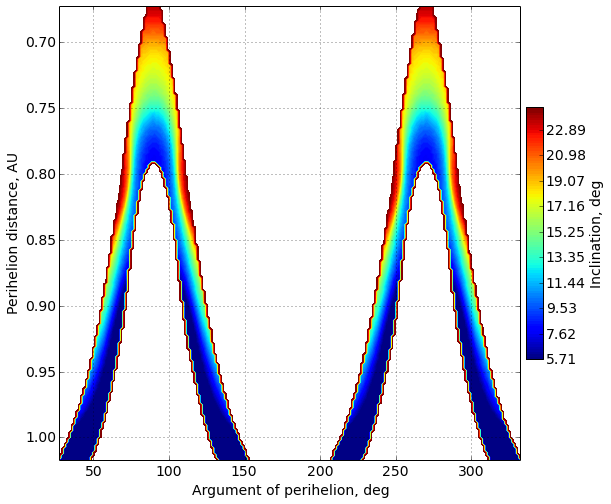

In [62]:
cutcol = ['w', 'q', 'i']
labels = [vd.colnames[nm] for nm in cutcol]
clf_masks = [(clfmask, 0), (clf_apollo_wq, 0)]
vd.plot_clf3d(clf_apollo_wqi, num=200, labels=labels, figsize=(8,7), mode='2d', 
              scales=apollo_wqi_sc, clf_masks=clf_masks, invertaxes=[0,1])

In [109]:
haz_extracted_ap_ms1.append(haz_gen_apollo_wqi)
nohaz_trapped_ap_ms1.append(nohaz_gen_apollo_wqi)

Extract PHA volume from the rest of the q-w split

In [64]:
# print len(haz_gen_apollo_wq__)
# print len(nohaz_gen_apollo_wq__)

In [65]:
# haz_gen_apollo_wq__si = haz_gen_apollo_wq__[haz_gen_apollo_wq__['i'] < 10]
# nohaz_gen_apollo_wq__si = nohaz_gen_apollo_wq__[nohaz_gen_apollo_wq__['i'] < 10]

In [66]:
# haz_gen_apollo_wq__si = pd.concat((haz_gen_apollo_wq__si, haz_gen_apollo_ai__))
# nohaz_gen_apollo_wq__si = pd.concat((nohaz_gen_apollo_wq__si, nohaz_gen_apollo_ai__))

In [67]:
# haz_gen_apollo_wq__se = ld.add_doublemirror_column(haz_gen_apollo_wq__si, 'w', 180.0)
# nohaz_gen_apollo_wq__se = ld.add_doublemirror_column(nohaz_gen_apollo_wq__si, 'w', 180.0)

In [68]:
# cutcol = ['w', 'q', 'i']
# clf = svm.SVC(gamma=30.0, C=1.0, class_weight={0: 1.5}) #class_weight={0: 1.5}
# apollo_wq_wqi, apollo_wq_wqi__, scales = al.split_by_clf(clf, cutcol, haz_gen_apollo_wq__se,
#                                                      nohaz_gen_apollo_wq__se,
#                                                      haz_gen_apollo_wq__si,
#                                                      nohaz_gen_apollo_wq__si)
# haz_gen_apollo_wq_wqi, nohaz_gen_apollo_wq_wqi = apollo_wq_wqi
# haz_gen_apollo_wq_wqi__, nohaz_gen_apollo_wq_wqi__ = apollo_wq_wqi__

In [69]:
# print len(haz_gen_apollo_wq_wqi)
# print len(nohaz_gen_apollo_wq_wqi)
# print
# print len(haz_gen_apollo_wq_wqi__)
# print len(nohaz_gen_apollo_wq_wqi__)

# print float(len(haz_gen_apollo_wq_wqi))/len(haz_gen_apollo_wq__si)

In [70]:
# vd.plot_clf3d(clf, num=80, labels=labels, figsize=(8,7), mode='2d', scales=scales)

In [71]:
# haz_gen_apollo_qa__se

### b) Alternative split sequence for Apollos

In [110]:
haz_extracted_ap_ms2 = copy(haz_extracted_ap_ms)
nohaz_trapped_ap_ms2 = copy(nohaz_trapped_ap_ms)

#### Split by w-q-i surface

In [73]:
cutcol = ['w', 'q', 'i']
clf_apollo_wqi2 = svm.SVC(gamma=30.0, C=0.3, class_weight={0: 1.5}) 
#(20 0.5), (30 0.1)
splitres = al.split_by_clf(clf_apollo_wqi2, cutcol,  haz_gen_apollo_qa__se,
                                                     nohaz_gen_apollo_qa__se,
                                                     haz_gen_apollo_qa__,
                                                     nohaz_gen_apollo_qa__)

haz_gen_apollo_wqi2, nohaz_gen_apollo_wqi2 = splitres[0]
haz_gen_apollo_wqi2__, nohaz_gen_apollo_wqi2__ = splitres[1]
apollo_wqi2_sc = splitres[2]

purity of PHA region: 0.89898989899
number of PHAs in the PHA region: 5251
number of NHAs in the PHA region: 590

purity of NHA region: 0.865457828015
number of PHAs in the NHA region: 3428
number of NHAs in the NHA region: 22051

fraction of correctly classified PHAs: 0.605023620233


** Prepare 'w-q' domain mask to exclude out-of-domain points from the plot **

In [74]:
cutcol = ['w', 'q']
labels = [vd.colnames[nm] for nm in cutcol]

clfmask = svm.SVC(gamma=50.0, C=100.0, class_weight={1: 10})
clfmask = al.sgmask_clf(haz_gen_apollo_qa__se, nohaz_gen_apollo_qa__se, 
                     haz_genu_rest, nohaz_genu_rest, clfmask, cutcol)

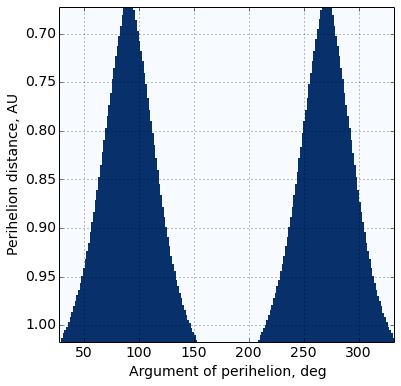

In [75]:
vd.plot_classifier(plotgrid, clfmask, num=200, figsize=(6,6), scales=apollo_wqi2_sc, 
                   labels = labels, cmap='Blues', invertaxes=[0, 1])

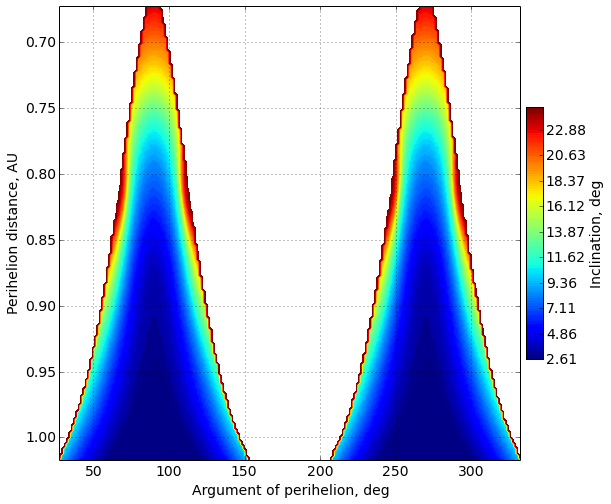

In [76]:
cutcol = ['w', 'q', 'i']
clf_masks = [(clfmask, 0)]
labels = [vd.colnames[nm] for nm in cutcol]
vd.plot_clf3d(clf_apollo_wqi2, num=200, labels=labels, figsize=(8,7), mode='2d', 
              scales=apollo_wqi2_sc, clf_masks=clf_masks, invertaxes=[0, 1]) 

In [111]:
haz_extracted_ap_ms2.append(haz_gen_apollo_wqi2)
nohaz_trapped_ap_ms2.append(nohaz_gen_apollo_wqi2)

In [78]:
# cutcol = ['w', 'q']
# labels = [vd.colnames[nm] for nm in cutcol]
# vd.display_param2d(cutcol, labels, [haz_genu_rest, nohaz_genu_rest])

In [79]:
# vd.display_param2d(cutcol, labels, [haz_gen_apollo_qa__se, nohaz_gen_apollo_qa__se])

In [80]:
# vd.display_param2d(cutcol, labels, [haz_genu_sg1, nohaz_genu_sg1])

In [81]:
# vd.display_allparams([haz_gen_apollo_qa_wqi__, nohaz_gen_apollo_qa_wqi__], vd.combs, vd.colnames)

** Amplify datasets by their symmetric copies over the 'w' parameter **

In [82]:
haz_gen_apollo_wqi2__se = ld.add_doublemirror_column(haz_gen_apollo_wqi2__, 'w', 180.0)
nohaz_gen_apollo_wqi2__se = ld.add_doublemirror_column(nohaz_gen_apollo_wqi2__, 'w', 180.0)

#### Split the rest of Apollos by the 'w-q-a' surface

In [83]:
cutcol = ['w', 'q', 'a']
clf_apollo_wqa2 = svm.SVC(gamma=20.0, C=0.5, class_weight={0: 1.5})
# (30 0.5)
splitres = al.split_by_clf(clf_apollo_wqa2, cutcol,  haz_gen_apollo_wqi2__se,
                                                     nohaz_gen_apollo_wqi2__se,
                                                     haz_gen_apollo_wqi2__,
                                                     nohaz_gen_apollo_wqi2__)

haz_gen_apollo_wqa2, nohaz_gen_apollo_wqa2 = splitres[0]
haz_gen_apollo_wqa2__, nohaz_gen_apollo_wqa2__ = splitres[1]
apollo_wqi2_sc = splitres[2]

purity of PHA region: 0.9
number of PHAs in the PHA region: 1260
number of NHAs in the PHA region: 140

purity of NHA region: 0.909963038332
number of PHAs in the NHA region: 2168
number of NHAs in the NHA region: 21911

fraction of correctly classified PHAs: 0.36756126021


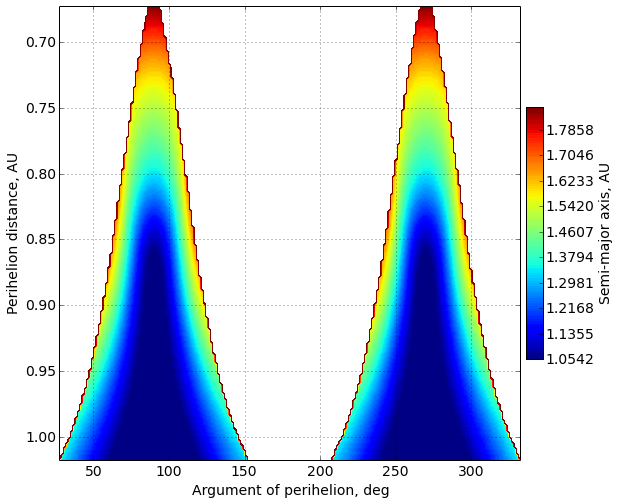

In [84]:
clf_masks = [(clfmask, 0)]
cutcol = ['w', 'q', 'a']
labels = [vd.colnames[nm] for nm in cutcol]
vd.plot_clf3d(clf_apollo_wqa2, num=200, labels=labels, figsize=(8,7), mode='2d', 
              scales=apollo_wqi2_sc, clf_masks=clf_masks, invertaxes=[0, 1])

In [112]:
haz_extracted_ap_ms2.append(haz_gen_apollo_wqa2)
nohaz_trapped_ap_ms2.append(nohaz_gen_apollo_wqa2)

In [86]:
# vd.display_allparams([haz_gen_apollo_wqa2__, nohaz_gen_apollo_wqa2__], vd.combs, vd.colnames)

### 2. Direct double-layer split approach for Apollos

** Amplify datasets by their symmetric copies over 'w' parameter **

In [87]:
# haz_gen_apollo_se = ld.add_mirror_column(haz_gen_apollo, 'w', 180.0)
# nohaz_gen_apollo_se = ld.add_mirror_column(nohaz_gen_apollo, 'w', 180.0)

haz_gen_apollo_se = ld.add_doublemirror_column(haz_gen_apollo, 'w', 180.0)
nohaz_gen_apollo_se = ld.add_doublemirror_column(nohaz_gen_apollo, 'w', 180.0)

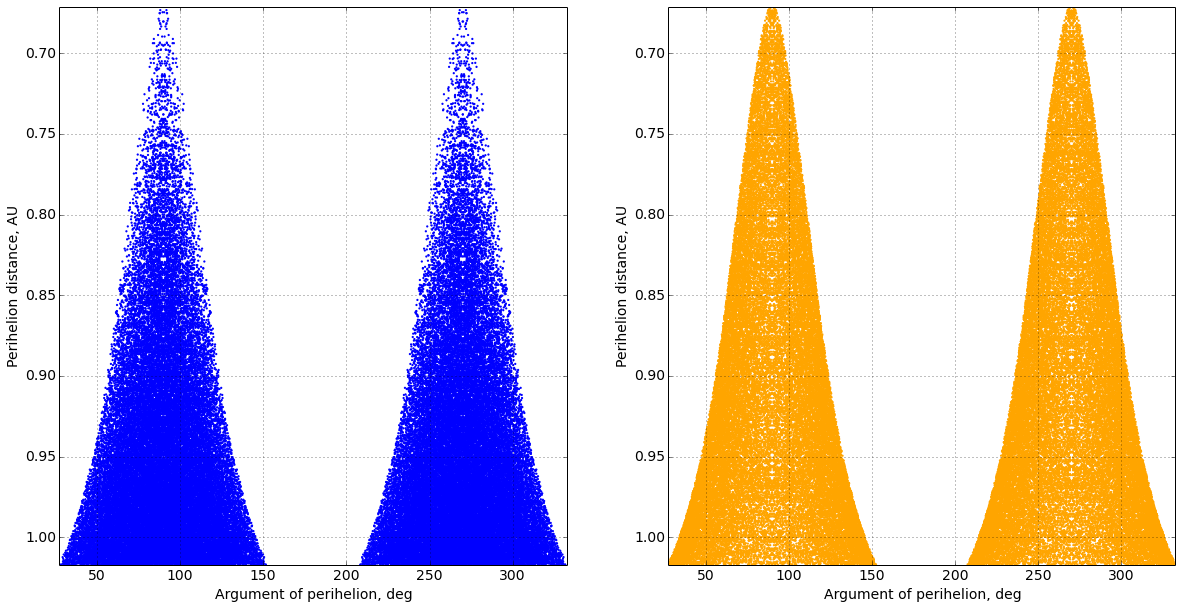

In [88]:
cutcol = ['w', 'q']
labels = [vd.colnames[nm] for nm in cutcol]
vd.display_param2d(cutcol, labels, [haz_gen_apollo_se, nohaz_gen_apollo_se], invertaxes=[0,1])

** Cut off annoying tips **

In [89]:
haz_gen_apollo_bq = haz_gen_apollo[haz_gen_apollo.q > 0.7]
nohaz_gen_apollo_bq = nohaz_gen_apollo[nohaz_gen_apollo.q > 0.7]

haz_gen_apollo_sq = haz_gen_apollo[haz_gen_apollo.q <= 0.7]
nohaz_gen_apollo_sq = nohaz_gen_apollo[nohaz_gen_apollo.q <= 0.7]

haz_gen_apollo_se_bq = haz_gen_apollo_se[haz_gen_apollo_se.q > 0.7]
nohaz_gen_apollo_se_bq = nohaz_gen_apollo_se[nohaz_gen_apollo_se.q > 0.7]

In [90]:
# vd.display_allparams([haz_gen_apollo_sq, nohaz_gen_apollo_sq], vd.combs, vd.colnames)

** Prepare w-q domain mask to exclude out-of-domain points from the plot **

In [91]:
cutcol = ['w', 'q']
labels = [vd.colnames[nm] for nm in cutcol]

clfmask = svm.SVC(gamma=10.0, C=1e3) # class_weight={1: 2}
clfmask = al.sgmask_clf(haz_gen_apollo_se, nohaz_gen_apollo_se, 
                        haz_genu_rest, nohaz_genu_rest, clfmask, cutcol)

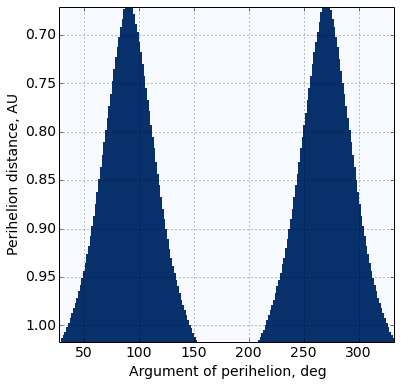

In [92]:
plotgrid = np.array([[0.0, 0.0], [1.0, 1.0]])
scales = ld.dfcommon_bounds([haz_gen_apollo_se, nohaz_gen_apollo_se], cutcol)
vd.plot_classifier(plotgrid, clfmask, num=200, figsize=(6,6), scales=scales, 
                   labels = labels, cmap='Blues', invertaxes=[0, 1])

** Split Apollos by the 'w-q-i' surface **

In [93]:
# reload(al)
cutcol = ['w', 'q', 'i']

clf_apollo_wqi3 = svm.SVC(gamma=40.0, C=0.05, class_weight={0: 1.2}) #class_weight={0: 1.5} 
# clf_apollo_wqi3 = svm.NuSVC(gamma=10.0, class_weight={0: 1.5}) #class_weight={0: 1.5}
#(20 0.5), (30 0.1) (5 0.01)
splitres = al.split_by_clf(clf_apollo_wqi3, cutcol,  haz_gen_apollo_se_bq,
                                                     nohaz_gen_apollo_se_bq,
                                                     haz_gen_apollo,
                                                     nohaz_gen_apollo)

haz_gen_apollo_wqi3, nohaz_gen_apollo_wqi3 = splitres[0]
haz_gen_apollo_wqi3__, nohaz_gen_apollo_wqi3__ = splitres[1]
apollo_wqi3_sc = splitres[2]

purity of PHA region: 0.914428121721
number of PHAs in the PHA region: 17429
number of NHAs in the PHA region: 1631

purity of NHA region: 0.82397090684
number of PHAs in the NHA region: 4550
number of NHAs in the NHA region: 21298

fraction of correctly classified PHAs: 0.792984212203


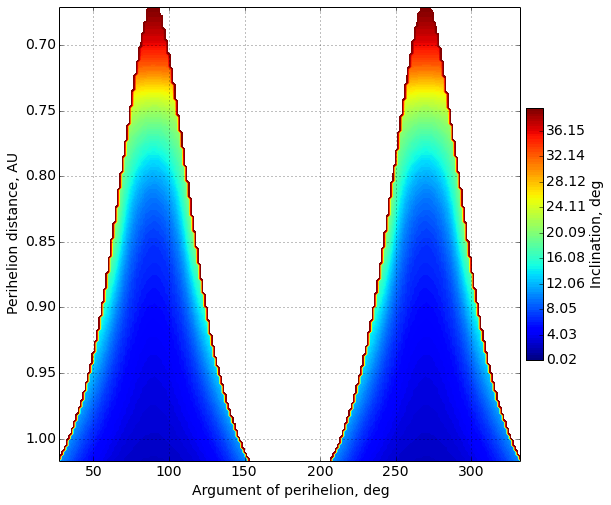

In [94]:
clf_masks = [(clfmask, 0)]
cutcol = ['w', 'q', 'i']
labels = [vd.colnames[nm] for nm in cutcol]
vd.plot_clf3d(clf_apollo_wqi3, num=200, labels=labels, figsize=(8,7), mode='2d', 
              scales=apollo_wqi3_sc, clf_masks=clf_masks, invertaxes=[0, 1])

In [113]:
haz_extracted_ap.append(haz_gen_apollo_wqi3)
nohaz_trapped_ap.append(nohaz_gen_apollo_wqi3)

** Analyze rest of Apollos **

** Amplify datasets by their symmetric copies over the 'w' parameter **

In [96]:
haz_gen_apollo_wqi3__se = ld.add_doublemirror_column(haz_gen_apollo_wqi3__, 'w', 180.0)
nohaz_gen_apollo_wqi3__se = ld.add_doublemirror_column(nohaz_gen_apollo_wqi3__, 'w', 180.0)

** Split the rest of Apollos by a 'w-q-a' surface **

In [97]:
# reload(al)
cutcol = ['w', 'q', 'a']
clf_apollo_wqa3 = svm.SVC(gamma=40.0, C=0.1, class_weight={0: 1.5}) #class_weight={0: 1.5}
# (30 0.5)
splitres = al.split_by_clf(clf_apollo_wqa3, cutcol,  haz_gen_apollo_wqi3__se,
                                                     nohaz_gen_apollo_wqi3__se,
                                                     haz_gen_apollo_wqi3__,
                                                     nohaz_gen_apollo_wqi3__)

haz_gen_apollo_wqa3, nohaz_gen_apollo_wqa3 = splitres[0]
haz_gen_apollo_wqa3__, nohaz_gen_apollo_wqa3__ = splitres[1]
apollo_wqa3_sc = splitres[2]

purity of PHA region: 0.910052910053
number of PHAs in the PHA region: 3096
number of NHAs in the PHA region: 306

purity of NHA region: 0.935222311325
number of PHAs in the NHA region: 1454
number of NHAs in the NHA region: 20992

fraction of correctly classified PHAs: 0.68043956044


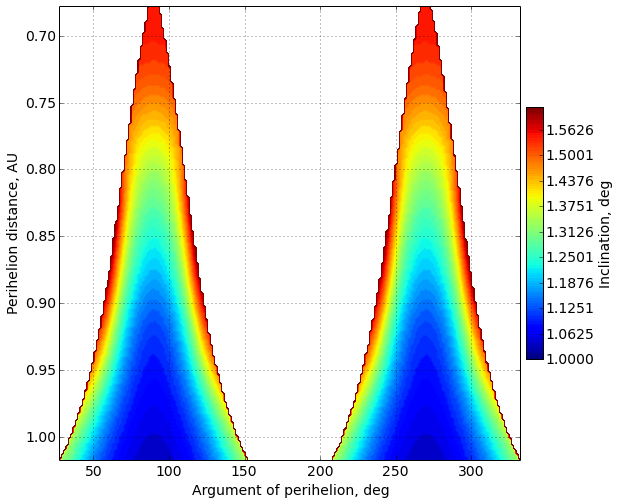

In [99]:
clf_masks = [(clfmask, 0)]
cutcol = ['w', 'q', 'i']
labels = [vd.colnames[nm] for nm in cutcol]
vd.plot_clf3d(clf_apollo_wqa3, num=200, labels=labels, figsize=(8,7), mode='2d', 
              scales=apollo_wqa3_sc, clf_masks=clf_masks, invertaxes=[0, 1])

In [114]:
haz_extracted_ap.append(haz_gen_apollo_wqa3)
nohaz_trapped_ap.append(nohaz_gen_apollo_wqa3)

---
## Extract Amors

In [115]:
haz_extracted_am = []
nohaz_trapped_am = []

In [116]:
haz_gen_amor, haz_am_num = rdb.get_amors(haz_gen_dom1)
nohaz_gen_amor, nohaz_am_num = rdb.get_amors(nohaz_gen_dom1)

In [117]:
# vd.display_allparams([haz_gen_amor, nohaz_gen_amor], vd.combs, vd.colnames)

### Cut off nonhazardous 'clouds' by w-i

In [118]:
haz_gen_amor_se = ld.add_doublemirror_column(haz_gen_amor, 'w', 180.0)
nohaz_gen_amor_se = ld.add_doublemirror_column(nohaz_gen_amor, 'w', 180.0)

In [119]:
reload(ld)
ef = 0.25
haz_gen_amor_see = ld.extend_by_copies(haz_gen_amor_se, 'w', extend_factor=ef)
nohaz_gen_amor_see = ld.extend_by_copies(nohaz_gen_amor_se, 'w', extend_factor=ef)

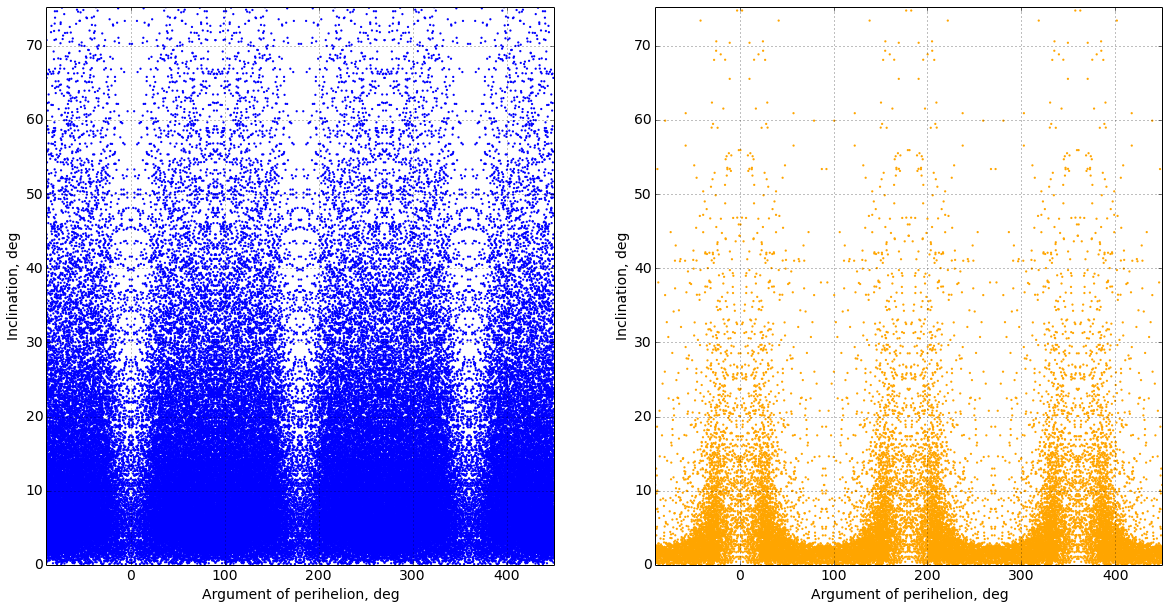

In [120]:
cutcol = ['w', 'i']
labels = [vd.colnames[nm] for nm in cutcol]
vd.display_param2d(cutcol, labels, [haz_gen_amor_see, nohaz_gen_amor_see])

In [121]:
reload(al)
clf_amor_wi = svm.SVC(gamma=30., C=0.1, class_weight={1: 5.5})
# clf = svm.SVC(gamma=12., C=0.02, class_weight={1: 5.5})
# clf = svm.SVC(gamma=10., C=0.08, class_weight={1: 5.5})
splitres = al.split_by_clf(clf_amor_wi, cutcol, haz_gen_amor_see, 
                                                nohaz_gen_amor_see, 
                                                haz_gen_amor, 
                                                nohaz_gen_amor)

haz_gen_amor_wi, nohaz_gen_amor_wi = splitres[0]
haz_gen_amor_wi__, nohaz_gen_amor_wi__ = splitres[1]
amor_wi_sc = splitres[2]

purity of PHA region: 0.360423668398
number of PHAs in the PHA region: 3539
number of NHAs in the PHA region: 6280

purity of NHA region: 0.962848505207
number of PHAs in the NHA region: 553
number of NHAs in the NHA region: 14332

fraction of correctly classified PHAs: 0.86485826002


In [122]:
# plotgrid = np.array([[0.0, 0.0], [1.0, 1.0]])
scales = deepcopy(amor_wi_sc)
# scales[0] = (0.0, 360.0)
wmin, wmax = min(haz_gen_amor['w']), max(haz_gen_amor['w'])
scales[0] = (wmin, wmax)
cx = ef * wmax / (wmax * (1.0 + 2 * ef))
plt_bounds = np.array([[cx, 0.0], [1-cx, 1.0]])

In [99]:
# print labels
# print scales
# print cutplotx
# print plt_bounds

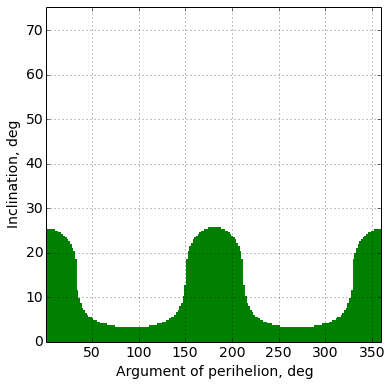

In [123]:
vd.plot_classifier(plt_bounds, clf_amor_wi, num=200, figsize=(6,6), scales=scales, 
                   labels=labels, cmap='ocean_r')
# vd.plot_classifier(plotgrid, clf_amor_wi, num=200, figsize=(6,6), scales=amor_wi_sc, 
#                    labels=labels, cmap='ocean_r')

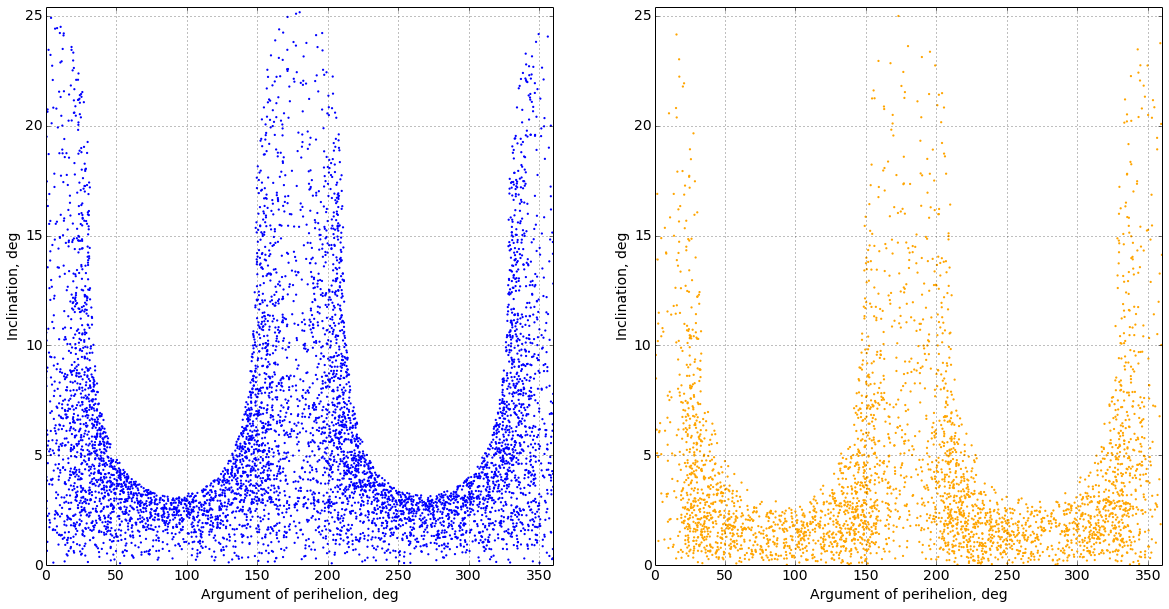

In [124]:
vd.display_param2d(cutcol, labels, [haz_gen_amor_wi, nohaz_gen_amor_wi])

### Extract PHA region by a 'w-om-q' surface

In [125]:
haz_gen_amor_wi_se = ld.add_mirror_column(haz_gen_amor_wi, 'w', 180.0)
nohaz_gen_amor_wi_se = ld.add_mirror_column(nohaz_gen_amor_wi, 'w', 180.0)

In [126]:
# ef = 0.25
# haz_gen_amor_wi_see = ld.extend_by_copies(haz_gen_amor_wi_se , 'w', extend_factor=ef)
# nohaz_gen_amor_wi_see = ld.extend_by_copies(nohaz_gen_amor_wi_se , 'w', extend_factor=ef)

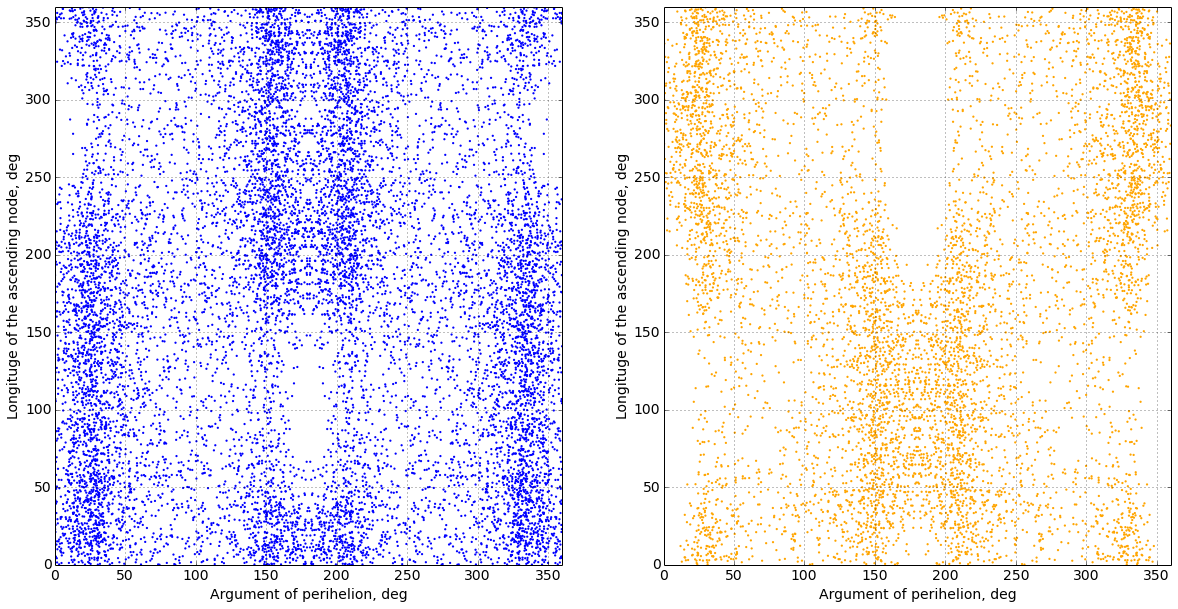

In [127]:
cutcol = ['w', 'om']
labels = [vd.colnames[nm] for nm in cutcol]
vd.display_param2d(cutcol, labels, [haz_gen_amor_wi_se, nohaz_gen_amor_wi_se])

In [128]:
cutcol = ['w', 'om', 'q']
# clf = svm.SVC(gamma=10.0, C=1000, class_weight={0: 2.0})
clf_amor_womq = svm.SVC(gamma=20.0, C=8.0, class_weight={0: 2.4})
splitres = al.split_by_clf(clf_amor_womq, cutcol, haz_gen_amor_wi_se, 
                                                  nohaz_gen_amor_wi_se,
                                                  haz_gen_amor_wi, 
                                                  nohaz_gen_amor_wi)

haz_gen_amor_wqom, nohaz_gen_amor_wqom = splitres[0]
haz_gen_amor_wqom__, nohaz_gen_amor_wqom__ = splitres[1]
amor_wqom_sc = splitres[2]

purity of PHA region: 0.880964339528
number of PHAs in the PHA region: 1754
number of NHAs in the PHA region: 237

purity of NHA region: 0.771972406745
number of PHAs in the NHA region: 1785
number of NHAs in the NHA region: 6043

fraction of correctly classified PHAs: 0.495620231704


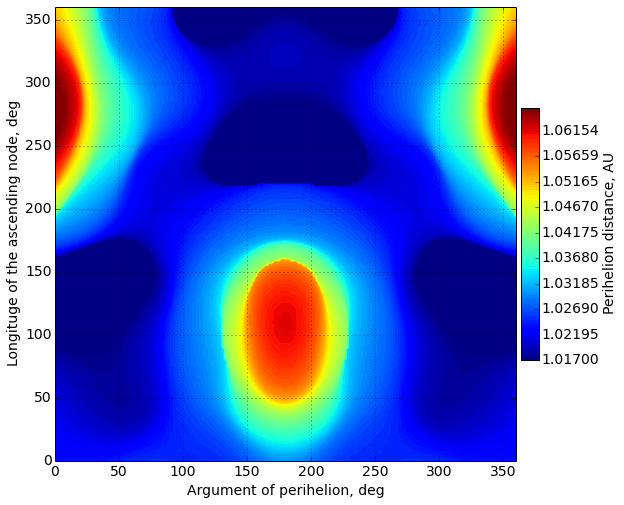

In [105]:
# reload(vd)
# %matplotlib auto
# %matplotlib inline
# vd.plot_scatter_clf3d(clf, num=30)
# scales[0] = (0.0, 360.0)
# cutplotx = ef * 360.0 / (360.0 * (1.0 + 2 * ef))
# plt_bounds = [[ef, 1-ef], [0.0, 1.0], [0.0, 1.0]]
cutcol = ['w', 'om', 'q']
labels = [vd.colnames[nm] for nm in cutcol]
vd.plot_clf3d(clf_amor_womq, num=200, labels=labels, figsize=(8,7), mode='2d', 
              scales=amor_wqom_sc) 
# plotbounds=plt_bounds

In [129]:
haz_extracted_am.append(haz_gen_amor_wqom)
nohaz_trapped_am.append(nohaz_gen_amor_wqom)

---
## Count down split quality

In [136]:
haz_extracted = haz_extracted_aa + haz_extracted_ap + haz_extracted_am
nohaz_trapped = nohaz_trapped_aa + nohaz_trapped_ap + nohaz_trapped_am

# haz_extracted = haz_extracted_aa + haz_extracted_ap_ms1 + haz_extracted_am
# nohaz_trapped = nohaz_trapped_aa + nohaz_trapped_ap_ms1 + nohaz_trapped_am

# haz_extracted = haz_extracted_aa + haz_extracted_ap_ms2 + haz_extracted_am
# nohaz_trapped = nohaz_trapped_aa + nohaz_trapped_ap_ms2 + nohaz_trapped_am

In [137]:
haz_correct_num = sum(map(len, haz_extracted))
nohaz_trapped_num = sum(map(len, nohaz_trapped))

haz_correct_fraction = float(haz_correct_num)/len(haz_gen)
nohaz_trapped_fraction = float(nohaz_trapped_num)/len(nohaz_gen)

haz_extracted_purity = float(haz_correct_num)/(nohaz_trapped_num + haz_correct_num)

print "Number of correctly classified PHAs", haz_correct_num
print "Number of trapped NHAs:", nohaz_trapped_num
print
print "Mass fraction of correctly classified PHAs:", haz_correct_fraction
print "Mass fraction of trapped NHAs:", nohaz_trapped_fraction
print "Cummulative purity of the outlined PHA regions:", haz_extracted_purity

Number of correctly classified PHAs 23291
Number of trapped NHAs: 2258

Mass fraction of correctly classified PHAs: 0.85865437788
Mass fraction of trapped NHAs: 0.0453231633882
Cummulative purity of the outlined PHA regions: 0.911620807077
